<a href="https://colab.research.google.com/github/Satya-1729/Python_machine_learning/blob/main/video%20colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import psutil
print(f"Total RAM: {psutil.virtual_memory().total / 1e9:.2f} GB")


Total RAM: 13.61 GB


In [2]:
# Clear variables
!pip install tensorflow
from IPython import get_ipython
get_ipython().magic('reset -sf')

# Clear memory from PyTorch (if used)
import gc
gc.collect()

# If using TensorFlow or Keras
import tensorflow as tf
tf.keras.backend.clear_session()

import torch
torch.cuda.empty_cache()



In [3]:
!pip install opencv-python
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
from tensorflow.keras.layers import Input,Dense,Reshape,Conv2D,Dropout,multiply,Dot,Concatenate,subtract,ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization,LeakyReLU,Flatten
from tensorflow.keras.layers import Conv2DTranspose as Deconv2d
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# from google.colab import files
from keras import backend as K
import smtplib

from sklearn.utils import shuffle

In [4]:
import tensorflow as tf
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import re
from tensorflow.keras.utils import img_to_array

In [5]:
!pip install kagglehub

In [6]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("theblackmamba31/landscape-image-colorization")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/landscape-image-colorization


In [50]:
# to get the files in proper order
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 256
color_img = []
path = '/kaggle/input/landscape-image-colorization/landscape Images/color'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
        if i == '200.jpg':
            break
        else:
            img = cv2.imread(path + '/'+i,1)
            # open cv reads images in BGR format so we have to convert it to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #resizing image
            img = cv2.resize(img, (SIZE, SIZE))
            img = img.astype('float32') / 255.0
            color_img.append(img_to_array(img))


gray_img = []
path = '/kaggle/input/landscape-image-colorization/landscape Images/gray'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
         if i == '200.jpg':
            break
         else:
            img = cv2.imread(path + '/'+i,1)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #resizing image
            img = cv2.resize(img, (SIZE, SIZE))
            img = img.astype('float32') / 255.0
            gray_img.append(img_to_array(img))

  3%|▎         | 200/7129 [00:00<00:14, 481.77it/s]


In [51]:
color_dataset=tf.data.Dataset.from_tensor_slices(np.array(color_img[:2000])).batch(32)
gray_dataset=tf.data.Dataset.from_tensor_slices(np.array(gray_img[:2000])).batch(32)

color_dataset_t=tf.data.Dataset.from_tensor_slices(np.array(color_img[2000:])).batch(8)
gray_dataset_t=tf.data.Dataset.from_tensor_slices(np.array(gray_img[2000:])).batch(8)

In [52]:
example_color = next(iter(color_dataset))
example_gray = next(iter(gray_dataset))

In [53]:
def plot_images(a = 4):

    for i in range(a):
        plt.figure(figsize = (10,10))
        plt.subplot(121)
        plt.title('color')
        plt.imshow(example_color[i] )

        plt.subplot(122)
        plt.title('gray')
        plt.imshow(example_gray[i])
        plt.show()

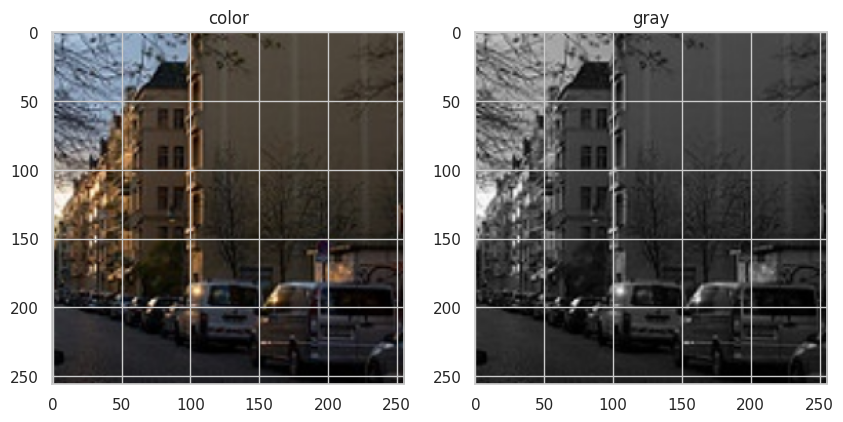

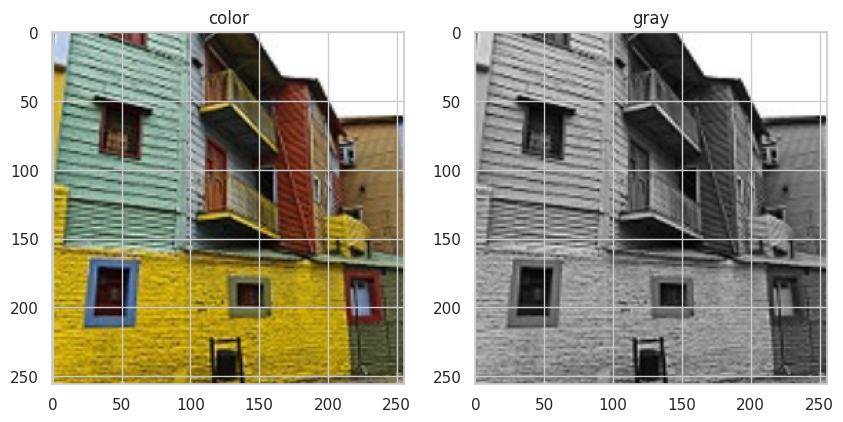

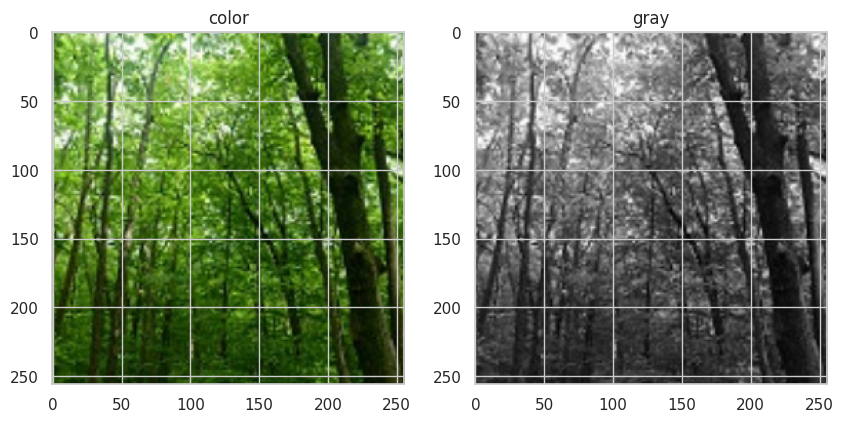

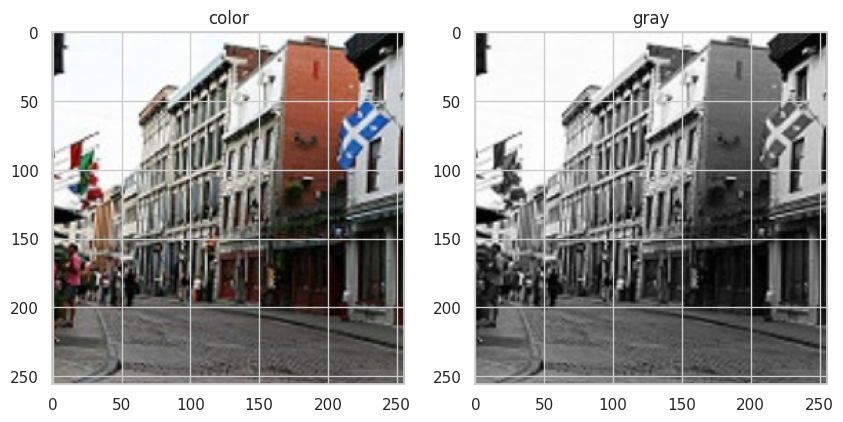

In [54]:
plot_images(4)

In [55]:
def downsample(filters, size, apply_batchnorm=True):

  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())
  return result

def upsample(filters, size, apply_dropout=False):

  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())
  return result

In [56]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(3, 4,strides=2,padding='same',kernel_initializer=initializer,activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [57]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [58]:
generator = Generator()
generator.summary()

Model: "functional_51"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_35      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_33       │ (None, 128, 128,  │      3,072 │ input_layer_35[0… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_34       │ (None, 64, 64,    │    131,584 │ sequential_33[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_35       │ (None, 32, 32,    │    525,312 │ sequential_34[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_36       │ (None, 16, 16,    │  2,099,200 │ sequential_35[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_37       │ (None, 8, 8, 512) │  4,196,352 │ sequential_36[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_38       │ (None, 4, 4, 512) │  4,196,352 │ sequential_37[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_39       │ (None, 2, 2, 512) │  4,196,352 │ sequential_38[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_40       │ (None, 1, 1, 512) │  4,196,352 │ sequential_39[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_41       │ (None, 2, 2, 512) │  4,196,352 │ sequential_40[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_15      │ (None, 2, 2,      │          0 │ sequential_41[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_39[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_42       │ (None, 4, 4, 512) │  8,390,656 │ concatenate_15[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 4, 4,      │          0 │ sequential_42[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_38[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_43       │ (None, 8, 8, 512) │  8,390,656 │ concatenate_16[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_17      │ (None, 8, 8,      │          0 │ sequential_43[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_37[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_44       │ (None, 16, 16,    │  8,390,656 │ concatenate_17[0… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_18      │ (None, 16, 16,    │          0 │ sequential_44[0]

 Total params: 54,425,859 (207.62 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 10,880 (42.50 KB)

In [59]:
discriminator = Discriminator()
discriminator.summary()

Model: "functional_55"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target_image        │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_22      │ (None, 256, 256,  │          0 │ input_image[0][0… │
│ (Concatenate)       │ 6)                │            │ target_image[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_48       │ (None, 128, 128,  │      6,144 │ concatenate_22[0… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_49       │ (None, 64, 64,    │    131,584 │ sequential_48[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_50       │ (None, 32, 32,    │    525,312 │ sequential_49[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 34, 34,    │          0 │ sequential_50[0]… │
│ (ZeroPadding2D)     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 31, 31,    │  2,097,152 │ zero_padding2d_2… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │      2,048 │ conv2d_32[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_31      │ (None, 31, 31,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 33, 33,    │          0 │ leaky_re_lu_31[0… │
│ (ZeroPadding2D)     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 30, 30, 1) │      8,193 │ zero_padding2d_3… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,770,433 (10.57 MB)

 Trainable params: 2,768,641 (10.56 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [60]:
genLoss=[]
discLoss=[]

In [61]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)
  genLoss.append(total_gen_loss)

  return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss
  discLoss.append(total_disc_loss)

  return total_disc_loss

In [62]:
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))


In [63]:
import time
def fit(train_ds, epochs,):
  for epoch in range(epochs):
    start = time.time()
    print("Epoch: ", epoch+1)
    # Train
    for n, (input_image, target) in train_ds.enumerate():
      train_step(input_image, target, epoch)
    print()
    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,time.time()-start))

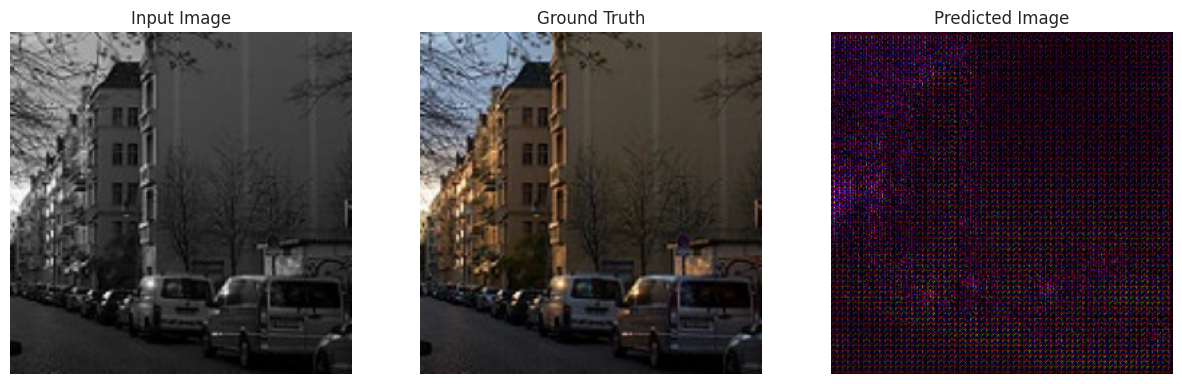

(32, 256, 256, 3)


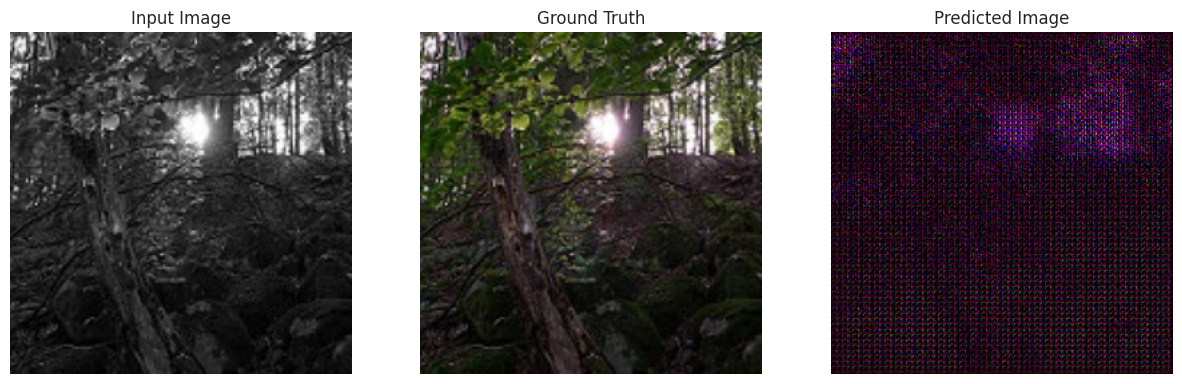

(32, 256, 256, 3)


In [64]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

for example_input, example_target in tf.data.Dataset.zip((gray_dataset,color_dataset)).take(2):
  generate_images(generator, example_input, example_target)
  print(example_input.shape)

In [65]:
hist=fit(tf.data.Dataset.zip((gray_dataset, color_dataset)), epochs = 10)

Epoch:  1

Time taken for epoch 1 is 15.055214405059814 sec

Epoch:  2

Time taken for epoch 2 is 20.58936858177185 sec

Epoch:  3

Time taken for epoch 3 is 11.628602027893066 sec

Epoch:  4

Time taken for epoch 4 is 11.642231702804565 sec

Epoch:  5

Time taken for epoch 5 is 11.56391954421997 sec

Epoch:  6

Time taken for epoch 6 is 11.4691002368927 sec

Epoch:  7

Time taken for epoch 7 is 11.493236541748047 sec

Epoch:  8

Time taken for epoch 8 is 11.513978719711304 sec

Epoch:  9

Time taken for epoch 9 is 11.458015441894531 sec

Epoch:  10

Time taken for epoch 10 is 11.508866548538208 sec



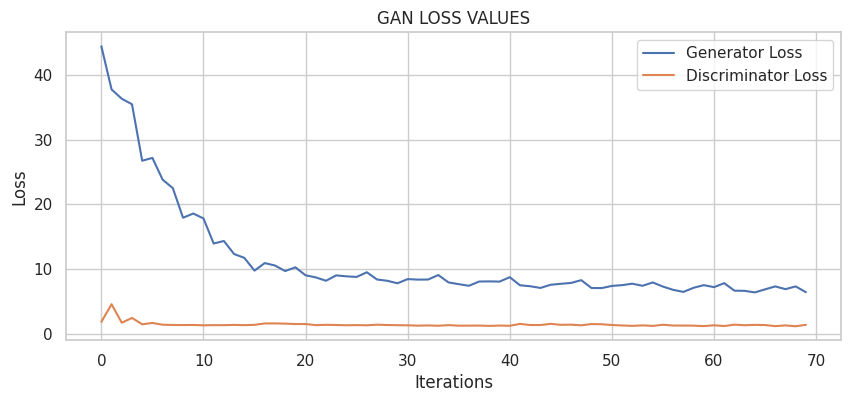

In [66]:
import seaborn as sns
sns.set(style='whitegrid')
plt.figure(figsize=(10,4))
plt.plot(genLoss, label="Generator Loss")
plt.plot(discLoss, label="Discriminator Loss")
plt.title("GAN LOSS VALUES")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


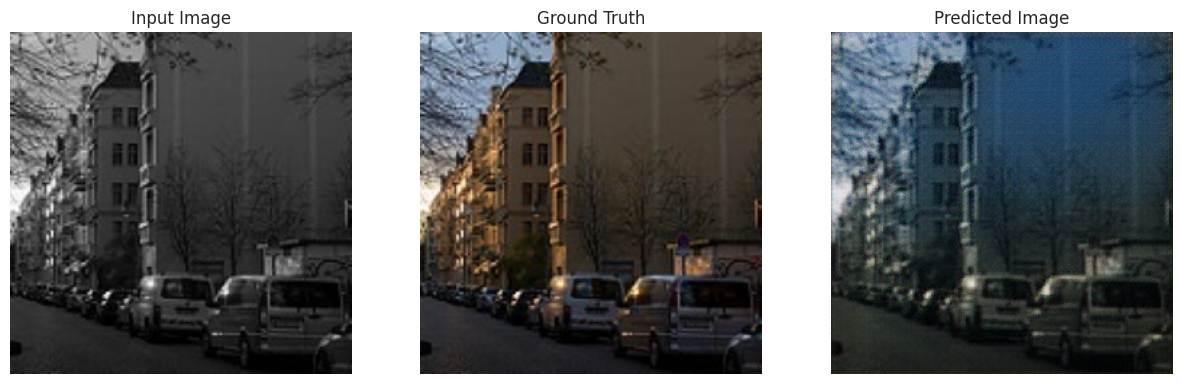

(32, 256, 256, 3)
(256, 256, 3)


(256, 256, 3)
(256, 256, 3)


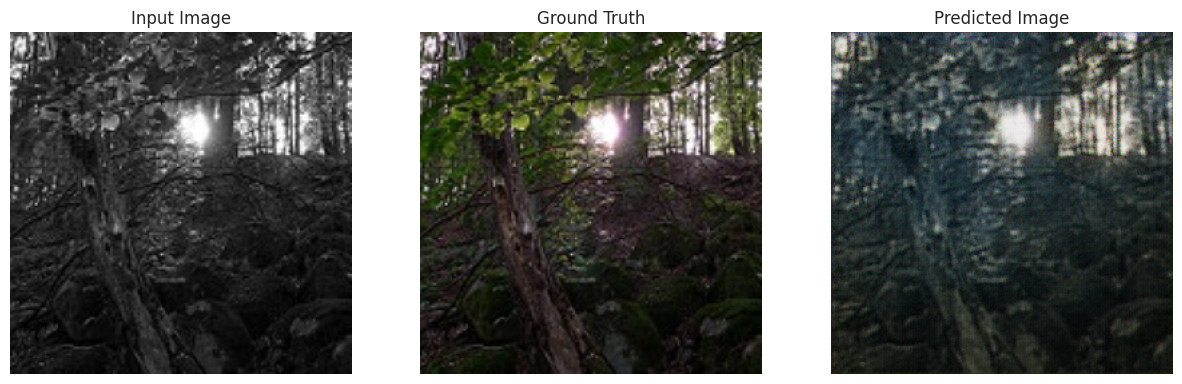

(32, 256, 256, 3)


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


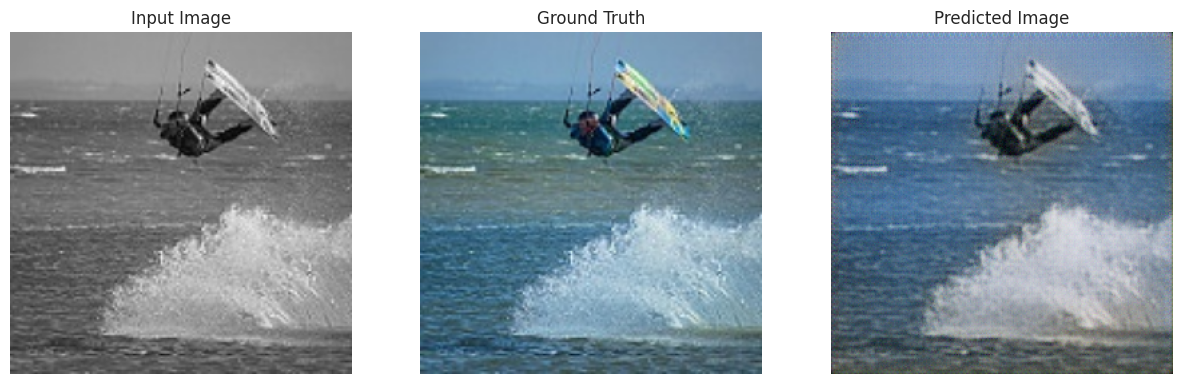

(32, 256, 256, 3)


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


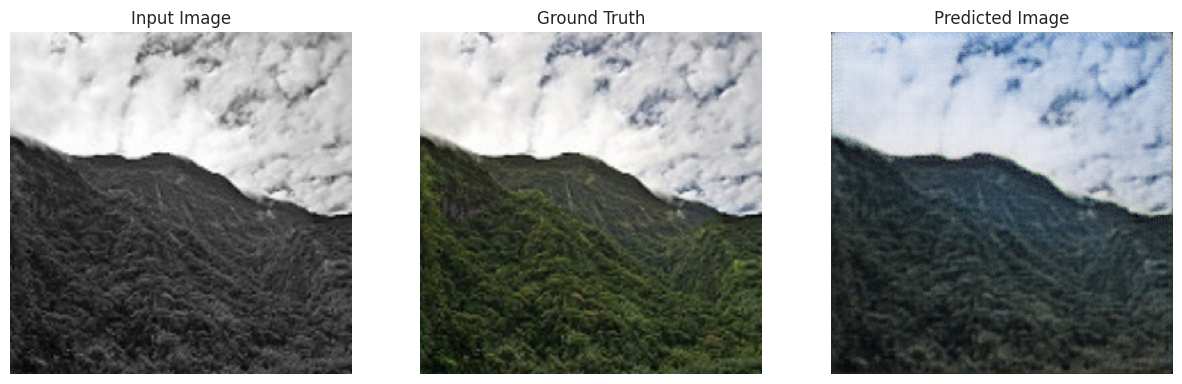

(32, 256, 256, 3)


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


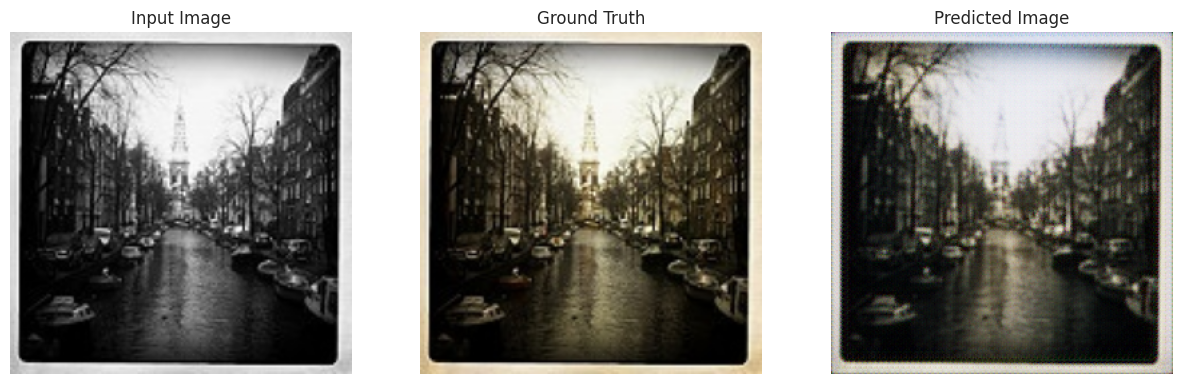

(32, 256, 256, 3)


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


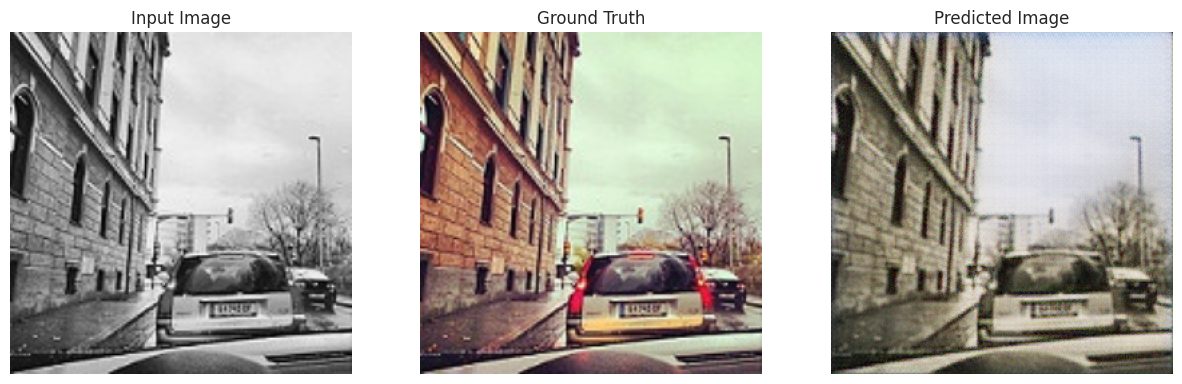

(32, 256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


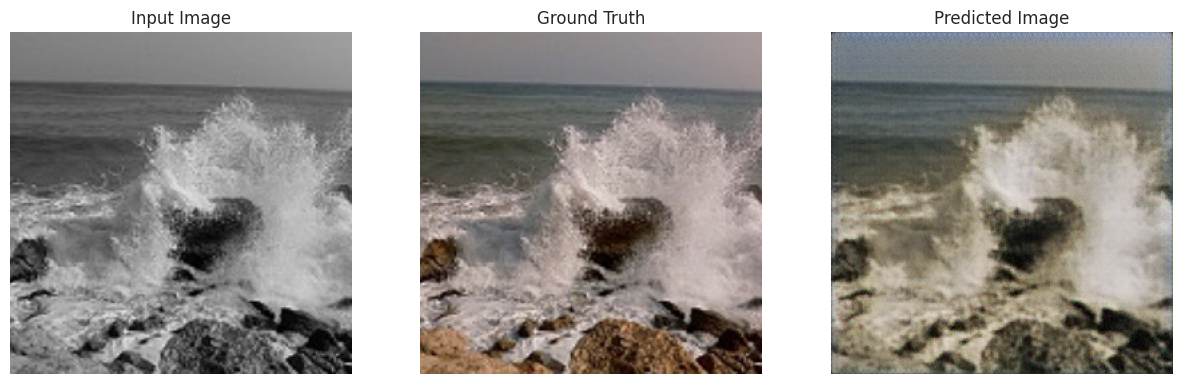

(8, 256, 256, 3)


In [67]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    print(test_input[0].shape)
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()


for example_input, example_target in tf.data.Dataset.zip((gray_dataset,color_dataset)).take(11):
  generate_images(generator, example_input, example_target)
  print(example_input.shape)

In [68]:
def mod(model, test_input):

    return model(test_input, training=True)

In [69]:
img2 = cv2.imread("/content/download.jpeg").astype("float32")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
# img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
try:
    img2 = img2.reshape(1,SIZE,SIZE,3)
except:
    img2 = cv2.resize(img2,(SIZE,SIZE))
    img2 = img2.reshape(1,SIZE,SIZE,3)

(1, 256, 256, 3)


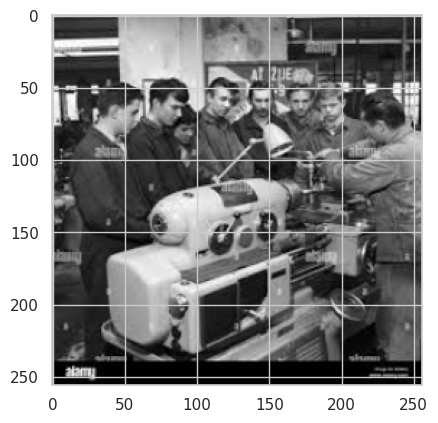

In [70]:
img2 = img2.reshape(1, SIZE, SIZE, 3)
print(img2.shape)

img2[0] = img2[0]/255.0

plt.imshow(img2[0])

In [71]:
img2

array([[[[0.6862745 , 0.6862745 , 0.6862745 ],
         [0.6801777 , 0.6801777 , 0.6801777 ],
         [0.6660999 , 0.6660999 , 0.6660999 ],
         ...,
         [0.20392157, 0.20392157, 0.20392157],
         [0.20392157, 0.20392157, 0.20392157],
         [0.20392157, 0.20392157, 0.20392157]],

        [[0.2980086 , 0.2980086 , 0.2980086 ],
         [0.2945136 , 0.2945136 , 0.2945136 ],
         [0.28749615, 0.28749615, 0.28749615],
         ...,
         [0.15036765, 0.15036765, 0.15036765],
         [0.15036765, 0.15036765, 0.15036765],
         [0.15036765, 0.15036765, 0.15036765]],

        [[0.17208946, 0.17208946, 0.17208946],
         [0.17134522, 0.17134522, 0.17134522],
         [0.17179197, 0.17179197, 0.17179197],
         ...,
         [0.16785386, 0.16785386, 0.16785386],
         [0.16785386, 0.16785386, 0.16785386],
         [0.16785386, 0.16785386, 0.16785386]],

        ...,

        [[0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


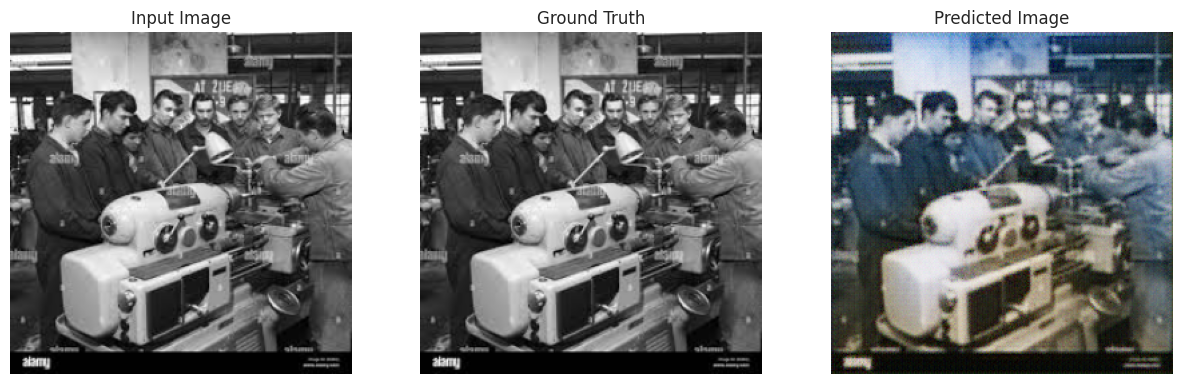

In [72]:
Pred=generate_images(generator,img2, img2)

In [73]:
import cv2
import numpy as np
import tensorflow as tf
import os
from pathlib import Path

In [74]:
def extract_frames(video_path, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    frame_count = 0

    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_path = os.path.join(output_dir, f"frame_{frame_count:04d}.jpg")
        cv2.imwrite(frame_path, frame)
        frame_count += 1

    cap.release()
    print(f"Extracted {frame_count} frames to {output_dir}.")

In [75]:
video_path = "/content/854336-hd_1920_1080_24fps.mp4"
frames_dir = "/kaggle/working/frame"

extract_frames(video_path, frames_dir)

Extracted 127 frames to /kaggle/working/frame.


In [76]:
SIZE = 256

In [77]:
def tensor_to_image(tensor):
    # Remove batch dimension if it exists
    if tensor.ndim == 4:  # Shape (batch, height, width, channels)
        tensor = tf.squeeze(tensor, axis=0)  # Remove the batch dimension

    # Clip values to [0, 1] and convert to [0, 255]
    tensor = tf.clip_by_value(tensor, 0.0, 1.0)  # Ensure values are in [0, 1]
    tensor = tensor.numpy() * 255  # Scale to [0, 255]
    tensor = tensor.astype(np.uint8)  # Convert to uint8

    # Convert from RGB to BGR if needed (for OpenCV)
    if tensor.shape[-1] == 3:  # Check if the image has 3 channels (RGB)
        tensor = cv2.cvtColor(tensor, cv2.COLOR_RGB2BGR)

    return tensor

In [78]:
import tensorflow as tf
import cv2

def mod(model, test_input):
    """
    Applies a model to a test input and returns the output.

    Args:
        model: The TensorFlow model to apply.
        test_input: The input data for the model.

    Returns:
        The output of the model.
    """
    return model(test_input, training=True)

In [79]:
generator = Generator()

In [80]:
for frame in os.listdir("/kaggle/working/frame"):
    img = cv2.imread(os.path.join("/kaggle/working/frame", frame)).astype("float32")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    try:
        img = img.reshape(1,SIZE,SIZE,3) # SIZE is now defined
    except:
        img = cv2.resize(img,(SIZE,SIZE)) # SIZE is now defined
        img = img.reshape(1,SIZE,SIZE,3) # SIZE is now defined
    img = img.reshape(1, SIZE, SIZE, 3) # SIZE is now defined
    img[0] = img[0]/255.0

    Pred=mod(generator,img)
    im = tensor_to_image(Pred)

    directory = '/kaggle/working/predicted_images'

    # Create the directory if it does not exist
    os.makedirs(directory, exist_ok=True)

    # Specify the full path to save the image
    save_path = os.path.join(directory, frame)

    # Save the image using OpenCV
    cv2.imwrite(save_path, im)


In [81]:
def reconstruct_video(output_path, frames_dir, fps):
    frame_files = sorted([f for f in os.listdir(frames_dir) if f.endswith('.jpg')])
    if not frame_files:
        print("Error: No frames found to reconstruct video.")
        return

    first_frame = cv2.imread(os.path.join(frames_dir, frame_files[0]))
    height, width, layers = first_frame.shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for frame_file in frame_files:
        frame_path = os.path.join(frames_dir, frame_file)
        frame = cv2.imread(frame_path)
        out.write(frame)

    out.release()
    print(f"Reconstructed video saved to {output_path}.")

In [82]:
out_path = "/content/satya/final_video.mp4"
col_frames_path = "/kaggle/working/predicted_images"
reconstruct_video(out_path, col_frames_path, 12)

Reconstructed video saved to /content/satya/final_video.mp4.
